In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas numpy plotly


In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
from scipy.stats import pearsonr
import glob
import plotly.express as px
import xarray as xr
import geopandas as gpd
import numpy as np

import plotly.graph_objects as go
from scipy import stats


In [ ]:
ERA_5_INDIA_DATA_DIR = "/content/drive/MyDrive/ERA_5_INDIA_DATA_DIR"

In [ ]:
#Computes relative humidity (RH) from temperature (t) and dewpoint temperature (d).
#Uses an empirical equation to estimate Wet Bulb Temperature (WBT).
#Returns WBT.

def calculate_wbt(t, d):
    """Approximate Wet Bulb Temperature (WBT) from temperature and dewpoint temperature."""
    rh = relative_humidity_from_dewpoint(t * units.degC, d * units.degC)
    wbt = t * np.arctan(0.151977 * (rh + 8.313659)**0.5) + \
          np.arctan(t + rh) - np.arctan(rh - 1.676331) + \
          0.00391838 * rh**1.5 * np.arctan(0.023101 * rh) - 4.686035
    return wbt

In [ ]:
# Reads a GeoJSON file containing state boundaries for India.
# This is used to map WBT values to specific states.
# Iterates through years (2000 to 2023).
# For each year, iterates through months (Jan-Dec).
# Processes WBT data monthly.
# Defines file paths for temperature (t2m) and dewpoint temperature (d2m) for a given month.
# Reads these NetCDF files using xarray
# ERA5 temperature data is in Kelvin, so we subtract 273.15 to convert to Celsius.
# Uses the calculate_wbt function to compute WBT for each grid point in the dataset.
# Converts xarray dataset into a pandas DataFrame.
# Renames columns for clarity.
# Creates geospatial points for each data location using longitude and latitude.
# Converts DataFrame to GeoDataFrame for spatial operations.
# Performs a spatial join to assign each WBT data point to the corresponding state.
# Extracts year, month, and day from the time column for grouping and analysis.
# Groups by year, month, day, and state (st_nm).

# Computes mean values for temperature, dewpoint, and WBT.
# Concatenates monthly WBT data into a single yearly DataFrame.
# Saves the results to a CSV file.
# Collects all yearly CSV files.
# Reads them into a list of DataFrames.
# Merges all years into a single CSV file.



# Load shapefile from GeoJSON
states_gdf = gpd.read_file("/content/drive/MyDrive/Indian_states/Indian_states.geojson")

for year in range(2000, 2024):
    year_wbt = []
    for month in range(1, 13):
        t2m_file_path = f"{ERA_5_INDIA_DATA_DIR}/max-1-hourly/{year}-{month}/2m_temperature_0_daily-max.nc"
        d2m_file_path = f"{ERA_5_INDIA_DATA_DIR}/max-1-hourly/{year}-{month}/2m_dewpoint_temperature_stream-oper_daily-max.nc"

        print(f"Processing {t2m_file_path}, {d2m_file_path}")

        # Load the netCDF files
        ds = xr.open_dataset(t2m_file_path)
        ds_d2m = xr.open_dataset(d2m_file_path)

        ds['t2m'] = ds['t2m'] - 273.15  # Convert to Celsius
        ds['d2m'] = ds_d2m['d2m'] - 273.15  # Convert to Celsius

        # Rename valid_time to time (if needed)
        if 'valid_time' in ds:
            ds = ds.rename({'valid_time': 'time'})

        # Apply WBT calculation
        ds['wbt'] = calculate_wbt(ds['t2m'], ds['d2m'])

        df = ds[['t2m', 'd2m', 'wbt']].to_dataframe().reset_index()
        df = df.rename(columns={'t2m': 'Temperature_C', 'd2m': 'Dewpoint_C', 'wbt': 'Wet_Bulb_Temperature_C'})

        # Convert DataFrame grid points to GeoDataFrame
        geometry = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]
        points_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

        # Perform spatial join to map points to states
        points_with_states = gpd.sjoin(points_gdf, states_gdf, how="inner", predicate="intersects")

        # Extract year, month and day from 'time' if it is a datetime object
        points_with_states['year'] = points_with_states['time'].dt.year
        points_with_states['month'] = points_with_states['time'].dt.month
        points_with_states['day'] = points_with_states['time'].dt.day

        # Group by year and state (using 'st_nm' for state names)
        year_wbt.append(points_with_states.groupby(['year', 'month', 'day', 'st_nm'])[['Temperature_C', 'Dewpoint_C', 'Wet_Bulb_Temperature_C']].mean().reset_index())

    # Concatenate all_wbt and save as a CSV file
    year_wbt_df = pd.concat(year_wbt, ignore_index=True)
    year_wbt_df.to_csv(f"{ERA_5_INDIA_DATA_DIR}/statewise_wbt_max_{year}_test.csv", index=False)

In [ ]:
# file path
# This CSV contains daily mean max temperature, dewpoint, and WBT for each state.

csv_files = glob.glob("/content/drive/MyDrive/ERA_5_INDIA_DATA_DIR/statewise_wbt_max_*_test.csv")

# Read and concatenate all CSVs
df_list = [pd.read_csv(file) for file in csv_files]
df_all = pd.concat(df_list, ignore_index=True)

# This final CSV contains daily records for every state over all years.
# Save the merged CSV
df_all.to_csv("/content/drive/MyDrive/ERA_5_INDIA_DATA_DIR/statewise_wbt_max_all_years.csv", index=False)

print("Merged CSV file saved successfully!")

# Each daily record is statewise, meaning temperature and dew point values are aggregated across grid points within each state.
# The final dataset provides a statewise daily time series from 2000 to 2023.
# All years are merged into a single statewise daily dataset.

"""Each daily record is statewise, meaning that:

    Temperature (t2m) values are aggregated across all grid points within each state.
    Dewpoint (d2m) values are also aggregated across all grid points within each state.
    Wet Bulb Temperature (WBT) is computed for each grid point, then aggregated statewise.

So for every state and day, the dataset contains:
 Mean temperature (°C) across the state
 Mean dewpoint (°C) across the state
 Mean wet bulb temperature (°C) across the state

These are saved daily in the statewise CSV files. """

##### Calculate heatwave days

In [ ]:
# Calculate heatwave days based on the criteia; If WBT exceeds 90th percentile or above for 3 consecutive days, then its considered as heatwave event.

# Ensure year, month, and day are properly converted to integers
for col in ['year', 'month', 'day']:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce').fillna(0).astype(int)

# Create the 'date' column
df_all['date'] = pd.to_datetime(df_all[['year', 'month', 'day']], errors='coerce')

# Ensure 'st_nm' is a string
df_all['st_nm'] = df_all['st_nm'].astype(str).fillna("Unknown_State")

# Ensure Wet_Bulb_Temperature_C is numeric
df_all['Wet_Bulb_Temperature_C'] = pd.to_numeric(df_all['Wet_Bulb_Temperature_C'], errors='coerce')

# Drop rows with missing temperature values
df_all = df_all.dropna(subset=['Wet_Bulb_Temperature_C'])

# Calculate the 90th percentile of Wet Bulb Temperature per state
percentile_90 = df_all.groupby('st_nm')['Wet_Bulb_Temperature_C'].quantile(0.90).rename("wbt_90th_percentile")

# Check if percentile_90 contains valid data
print("90th Percentile Data Sample:\n", percentile_90.head())

# Drop existing column before merging to avoid duplication issues
if "wbt_90th_percentile" in df_all.columns:
    df_all = df_all.drop(columns=["wbt_90th_percentile"])

# Merge the computed percentiles into df_all
df_all = df_all.merge(percentile_90, on="st_nm", how="left")

# Verify if 'wbt_90th_percentile' exists in df_all
print("Columns in df_all after merging:", df_all.columns)

# Flag heatwave days where WBT exceeds the 90th percentile
df_all['heatwave_flag'] = df_all['Wet_Bulb_Temperature_C'] >= df_all['wbt_90th_percentile']
df_all['heatwave_flag'] = df_all['heatwave_flag'].astype(int)  # Convert Boolean to int

# Sort by state and date before processing streaks
df_all = df_all.sort_values(by=['st_nm', 'date']).reset_index(drop=True)

# Identify consecutive heatwave streaks (at least 3 days)
df_all['streak'] = df_all.groupby('st_nm')['heatwave_flag'].apply(
    lambda x: x * (x.groupby((x == 0).cumsum()).cumcount() + 1)
).reset_index(drop=True)

# Flag heatwave events where streak is 3 or more consecutive days
df_all['heatwave_event'] = df_all['streak'] >= 3

# Count heatwave days per state and year
heatwave_stats = df_all[df_all['heatwave_event']].groupby(['year', 'st_nm']).agg(
    heatwave_days=('heatwave_event', 'sum'),
    median_wbt=('Wet_Bulb_Temperature_C', 'median')
).reset_index()

# Save the results
output_path = "/content/drive/MyDrive/ERA_5_INDIA_DATA_DIR/heatwave_summary.csv"
heatwave_stats.to_csv(output_path, index=False)

In [4]:
heat_stroke = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/heat-stroke-deaths.csv")
heatwave_summary = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/heatwave_summary.csv")

In [5]:
# Melt the heat stroke deaths dataset to long format
heat_stroke_deaths_long = heat_stroke.melt(id_vars=["state_ut"], var_name="year", value_name="deaths")

# Convert year to integer for merging compatibility
heat_stroke_deaths_long["year"] = heat_stroke_deaths_long["year"].astype(int)

# Standardizing column names for merging
heatwave_summary.rename(columns={"st_nm": "state_ut"}, inplace=True)

# Merge datasets on state and year
merged_df = pd.merge(heat_stroke_deaths_long, heatwave_summary, on=["state_ut", "year"], how="inner")

# Display the first few rows of the merged dataset
merged_df.head()

,state_ut,year,deaths,heatwave_days,median_wbt
0,Andhra Pradesh,2001,46,20,22.679109
1,Assam,2001,7,7,19.547613
2,Bihar,2001,47,5,23.027893
3,Chhattisgarh,2001,5,22,22.919030
4,Goa,2001,6,3,19.366161


In [6]:

heat_stroke = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/heat-stroke-deaths.csv")
heatwave = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/merged.csv")

In [7]:
heatwave.head(3)

,Unnamed: 0,state_ut,year,deaths,heatwave_days,median_wbt
0,0,Andhra Pradesh,2001,46,20,22.679109
1,1,Assam,2001,7,7,19.547613
2,2,Bihar,2001,47,5,23.027893


In [9]:
# Plot year-wise total heat-related deaths

# Load the heat stroke deaths dataset
heat_stroke = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/heat-stroke-deaths.csv")

# Convert wide format (years as columns) to long format
heat_stroke_long = heat_stroke.melt(id_vars=['state_ut'], var_name='year', value_name='heat_deaths')

# Convert 'year' to integer
heat_stroke_long['year'] = heat_stroke_long['year'].astype(int)

# Group by year to get total heat deaths per year
heat_deaths_per_year = heat_stroke_long.groupby('year')['heat_deaths'].sum().reset_index()

# Create an interactive plot using Plotly
fig = px.line(heat_deaths_per_year, x='year', y='heat_deaths',
              title="Heat-Related Deaths in India (2001-2022)",
              labels={'year': 'Year', 'heat_deaths': 'Total Heat Deaths'},
              markers=True,  # Add markers to the line
              template="plotly_white")

# Customize the layout
fig.update_layout(
    xaxis=dict(tickangle=-45, showgrid=True),  # Rotate x-axis labels and show grid
    yaxis=dict(showgrid=True),  # Show grid on y-axis
    hovermode="x unified"  # Show hover information for all points on the x-axis
)

# Show the interactive plot
fig.show()

In [13]:
# Create a scatter plot with a trend line
fig = px.scatter(heat_deaths_per_year, x='year', y='heat_deaths',
                 title="Heat-Related Deaths in India (2001-2022)",
                 labels={'year': 'Year', 'heat_deaths': 'Total Heat Deaths'},
                 trendline="ols")  # Ordinary Least Squares regression line
                 #template="plotly_dark")

# Add a line connecting the points
fig.add_trace(go.Scatter(x=heat_deaths_per_year['year'],
                         y=heat_deaths_per_year['heat_deaths'],
                         mode='lines+markers',
                         name='Actual Deaths Data'))

# Customize the layout
fig.update_layout(
    xaxis=dict(tickangle=-45, showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode="x unified",
    showlegend=True,
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",  # Align to the bottom of the legend box
        y=1.1,  # Position above the plot area
        xanchor="center",  # Center the legend
        x=0.5  # Set horizontal position to the middle
    )
)


In [ ]:
fig2 = px.line(
    heatwave,
    x="year",
    y="deaths",
    color="state_ut",
    markers=True,
    title="State-wise Heat-Related Deaths Over Years",
    labels={"year": "Year", "deaths": "Deaths"},
    template="plotly_dark"
)
fig2.show()

In [ ]:
# Find the Correlation Between Heatwave Days & Deaths
correlation = heatwave["heatwave_days"].corr(heatwave["deaths"])
print(f"Correlation between Heatwave Days and Heat-Related Deaths: {correlation:.3f}")

# Interactive Heatwave Days & Deaths Plot
fig1 = px.scatter(
    heatwave,
    x="heatwave_days",
    y="deaths",
    color="state_ut",
    size="deaths",
    hover_data=["year"],
    title="Heatwave Days vs. Heat-Related Deaths (State-wise)",
    labels={"heatwave_days": "Heatwave Days", "deaths": "Heat-Related Deaths"},
    template="plotly_dark"
)
fig1.show()




Correlation between Heatwave Days and Heat-Related Deaths: 0.221


In [ ]:
# Find Top & Bottom 3 States by Total Deaths
state_deaths = heatwave.groupby("state_ut")["deaths"].sum().sort_values(ascending=False)

top_3_states = state_deaths.head(3)
bottom_3_states = state_deaths.tail(3)

print("\nTop 3 States with Highest Heat-Related Deaths:")
print(top_3_states)

print("\nBottom 3 States with Lowest Heat-Related Deaths:")
print(bottom_3_states)




Top 3 States with Highest Heat-Related Deaths:
state_ut
Andhra Pradesh    4906
Uttar Pradesh     2861
Punjab            2205
Name: deaths, dtype: int64

Bottom 3 States with Lowest Heat-Related Deaths:
state_ut
Chandigarh    1
Puducherry    0
Manipur       0
Name: deaths, dtype: int64


In [ ]:
# Plot Top & Bottom 3 States
fig3 = px.bar(
    state_deaths,
    x=state_deaths.index,
    y=state_deaths.values,
    title="Total Heat-Related Deaths per State",
    labels={"x": "State", "y": "Total Deaths"},
    template="plotly_dark"
)
fig3.show()

In [ ]:
# Aggregate total heatwave days per state
state_heatwave_days = heatwave.groupby("state_ut")["heatwave_days"].sum().sort_values(ascending=False)

# Plot heatwave days per state
fig4 = px.bar(
    state_heatwave_days,
    x=state_heatwave_days.index,
    y=state_heatwave_days.values,
    title="Total Heatwave Days per State",
    labels={"x": "State", "y": "Total Heatwave Days"},
    template="plotly_dark"
)

fig4.show()


In [ ]:
import plotly.graph_objects as go

# Aggregate total heatwave days and deaths per state
state_heatwave_days = heatwave.groupby("state_ut")["heatwave_days"].sum().sort_values(ascending=False)
state_deaths = heatwave.groupby("state_ut")["deaths"].sum().sort_values(ascending=False)

# Create figure with two y-axes
fig = go.Figure()

# Add Heatwave Days (Left Axis)
fig.add_trace(go.Bar(
    x=state_heatwave_days.index,
    y=state_heatwave_days.values,
    name="Total Heatwave Days",
    marker_color="orange",
    yaxis="y1"
))

# Add Heat-Related Deaths (Right Axis)
fig.add_trace(go.Bar(
    x=state_deaths.index,
    y=state_deaths.values,
    name="Total Heat-Related Deaths",
    marker_color="red",
    yaxis="y2"
))

# Layout settings
fig.update_layout(
    title="Total Heatwave Days & Heat-Related Deaths per State",
    xaxis=dict(title="State"),
    yaxis=dict(
        title="Total Heatwave Days",
        titlefont=dict(color="orange"),
        tickfont=dict(color="orange"),
    ),
    yaxis2=dict(
        title="Total Heat-Related Deaths",
        titlefont=dict(color="red"),
        tickfont=dict(color="red"),
        overlaying="y",
        side="right"
    ),
    legend=dict(
        x=1.05,  # Moves the legend to the right side
        y=1,  # Aligns the legend to the top
        xanchor="left",
        yanchor="top"
    ),
    template="plotly_dark",
    barmode="group"  # Group bars side by side
)

fig.show()


In [ ]:
# Plot Total Deaths for Top 3 & Bottom 3 States
# Top 3 States Plot
fig3 = px.bar(
    top_3_states,
    x=top_3_states.index,
    y=top_3_states.values,
    title="Top 3 States with Highest Heat-Related Deaths",
    labels={"x": "State", "y": "Total Deaths"},
    color=top_3_states.index,
)
fig3.show()

# Bottom 3 States Plot
fig4 = px.bar(
    bottom_3_states,
    x=bottom_3_states.index,
    y=bottom_3_states.values,
    title="Bottom 3 States with Lowest Heat-Related Deaths",
    labels={"x": "State", "y": "Total Deaths"},
    color=bottom_3_states.index,
)
fig4.show()

In [ ]:
# Aggregate total deaths by state
state_deaths = heatwave.groupby("state_ut")["deaths"].sum().sort_values(ascending=False)

# Select top 3 and bottom 3 states
top_3_states = state_deaths.head(3)
bottom_3_states = state_deaths.tail(3)

# Combine them into a single DataFrame
top_bottom_states = pd.concat([top_3_states, bottom_3_states]).reset_index()
top_bottom_states.columns = ["State", "Total Deaths"]

# Create the bar chart
fig = px.bar(
    top_bottom_states,
    x="State",
    y="Total Deaths",
    title="Top 3 and Bottom 3 States with Heat-Related Deaths",
    labels={"State": "State", "Total Deaths": "Total Deaths"},
    color="State",
    text="Total Deaths",
    template="plotly_dark"
)

fig.update_traces(textposition="outside")
fig.show()

In [12]:
# Bivariate Correlation (Heatwave Days vs. Deaths)
correlation, p_value = pearsonr(heatwave["heatwave_days"], heatwave["deaths"])
print(f"Bivariate Correlation between Heatwave Days and Heat-Related Deaths: {correlation:.3f}")
print(f"P-value: {p_value:.5f}")

# Global Analysis of Heatwave Days & Deaths

# Aggregate global stats (sum over all states per year)
global_trend = heatwave.groupby("year")[["heatwave_days", "deaths"]].sum().reset_index()

# Interactive line plot for Global Trends
fig = px.line(
    global_trend,
    x="year",
    y=["heatwave_days", "deaths"],
    markers=True,
    title="Global Heatwave Days & Heat-Related Deaths Over Years",
    labels={"value": "Count", "year": "Year"},
    #template="plotly_dark"
)
fig.show()

Bivariate Correlation between Heatwave Days and Heat-Related Deaths: 0.221
P-value: 0.00000


In [ ]:
# State-wise Heatwave Trends

# Interactive line plot for state-wise heatwave trends
fig2 = px.line(
    heatwave,
    x="year",
    y="deaths",
    color="state_ut",
    markers=True,
    title="State-wise Heat-Related Deaths Over Years",
    labels={"year": "Year", "deaths": "Heat-Related Deaths"},
    template="plotly_dark"
)
fig2.show()

In [ ]:
# Filter data for the year 2015
heatwave_2015 = heatwave[heatwave["year"] == 2015]

# Scatter Plot: Heatwave Days vs. Deaths (2015)
fig1 = px.scatter(
    heatwave_2015,
    x="heatwave_days",
    y="deaths",
    color="state_ut",
    size="deaths",
    hover_data=["state_ut"],
    title="Heatwave Days vs. Heat-Related Deaths (2015)",
    labels={"heatwave_days": "Heatwave Days", "deaths": "Heat-Related Deaths"},
    template="plotly_dark"
)
fig1.show()



In [ ]:
# Bar Plot: State-wise Heat-Related Deaths in 2015
fig2 = px.bar(
    heatwave_2015,
    x="state_ut",
    y="deaths",
    color="deaths",
    text="deaths",
    title="State-wise Heat-Related Deaths (2015)",
    labels={"state_ut": "State/UT", "deaths": "Heat-Related Deaths"},
    template="plotly_dark"
)
fig2.update_traces(textposition="outside")
fig2.show()


In [9]:
heatwave = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/merged.csv")

In [10]:
heatwave.head()

,Unnamed: 0,state_ut,year,deaths,heatwave_days,median_wbt
0,0,Andhra Pradesh,2001,46,20,22.679109
1,1,Assam,2001,7,7,19.547613
2,2,Bihar,2001,47,5,23.027893
3,3,Chhattisgarh,2001,5,22,22.919030
4,4,Goa,2001,6,3,19.366161


In [14]:
pop_density = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/population_density_2001_2022.csv")
pop_density.head(3)

,Year,Population Density
0,2001,320.5
1,2002,328.2
2,2003,336.1


In [15]:
# Rename columns in population density dataset for consistency
pop_density.rename(columns={"Year": "year", "Population Density": "population_density"}, inplace=True)

# Merge with heatwave data based on year
merged_df = heatwave.merge(pop_density, on="year", how="left")


In [16]:
merged_df.head(10)

,Unnamed: 0,state_ut,year,deaths,heatwave_days,median_wbt,population_density
0,0,Andhra Pradesh,2001,46,20,22.679109,320.5
1,1,Assam,2001,7,7,19.547613,320.5
2,2,Bihar,2001,47,5,23.027893,320.5
3,3,Chhattisgarh,2001,5,22,22.919030,320.5
4,4,Goa,2001,6,3,19.366161,320.5
5,5,Gujarat,2001,24,12,23.625233,320.5
6,6,Haryana,2001,1,20,23.656543,320.5
7,7,Himachal Pradesh,2001,2,26,11.529877,320.5
8,8,Jharkhand,2001,2,10,22.315289,320.5
9,9,Karnataka,2001,2,16,20.665346,320.5


In [22]:
import numpy as np

# Aggregate total heatwave deaths & days by year
global_data = merged_df.groupby("year")[["deaths", "heatwave_days"]].sum().reset_index()

# Merge with population density
global_data = global_data.merge(pop_density, on="year", how="left")

# Compute correlation
correlation = np.corrcoef(global_data["population_density"], global_data["deaths"])[0, 1]
print(f"Correlation between Population Density and Heat-Related Deaths: {correlation:.3f}")


Correlation between Population Density and Heat-Related Deaths: 0.582


In [ ]:
import plotly.express as px

fig = px.line(
    global_data,
    x="year",
    y=["population_density", "deaths"],
    markers=True,
    title="Population Density vs. Heat-Related Deaths Over Time",
    labels={"value": "Count", "year": "Year"},
    template="plotly_dark"
)
fig.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Add Heat-Related Deaths (Left Y-Axis)
fig.add_trace(go.Scatter(
    x=global_data["year"],
    y=global_data["deaths"],
    mode="lines+markers",
    name="Heat-Related Deaths",
    marker=dict(color="red"),
    yaxis="y1"
))

# Add Population Density (Right Y-Axis)
fig.add_trace(go.Scatter(
    x=global_data["year"],
    y=global_data["population_density"],
    mode="lines+markers",
    name="Population Density",
    marker=dict(color="blue"),
    yaxis="y2"
))

# Layout settings
fig.update_layout(
    title="Population Density vs. Heat-Related Deaths Over Time",
    xaxis=dict(title="Year"),

    # Left Y-Axis (Heat-Related Deaths)
    yaxis=dict(
        title="Heat-Related Deaths",
        titlefont=dict(color="red"),
        tickfont=dict(color="red"),
    ),

    # Right Y-Axis (Population Density)
    yaxis2=dict(
        title="Population Density",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue"),
        overlaying="y",
        side="right"
    ),

    legend=dict(
        x=1.05,  # Moves the legend to the right
        y=1,
        xanchor="left",
        yanchor="top"
    ),

    template="plotly_dark"
)

fig.show()


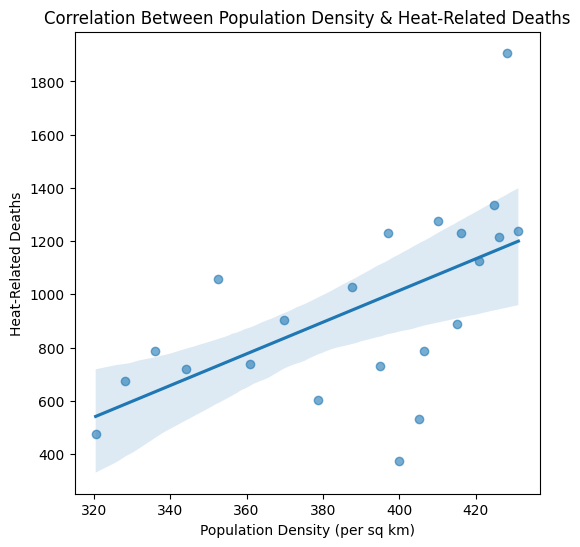

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
sns.regplot(data=global_data, x="population_density", y="deaths", scatter_kws={'alpha':0.6})
plt.xlabel("Population Density (per sq km)")
plt.ylabel("Heat-Related Deaths")
plt.title("Correlation Between Population Density & Heat-Related Deaths")
plt.show()


In [28]:
import plotly.express as px

# Create an interactive scatter plot with a trend line
fig = px.scatter(
    global_data,
    x="population_density",
    y="deaths",
    trendline="ols",  # Ordinary Least Squares (OLS) regression line
    opacity=0.6,  # Similar to scatter_kws={'alpha': 0.6}
    title="Correlation Between Population Density & Heat-Related Deaths",
    labels={"population_density": "Population Density (per sq km)", "deaths": "Heat-Related Deaths"}
)

# Customize the trendline's appearance
for trace in fig.data:
    if "trendline" in trace.name:  # Identifying the regression line
        trace.line.width = 3  # Make the line thicker
        trace.line.color = "red"  # Set a contrasting color

# Show the interactive plot
fig.show()



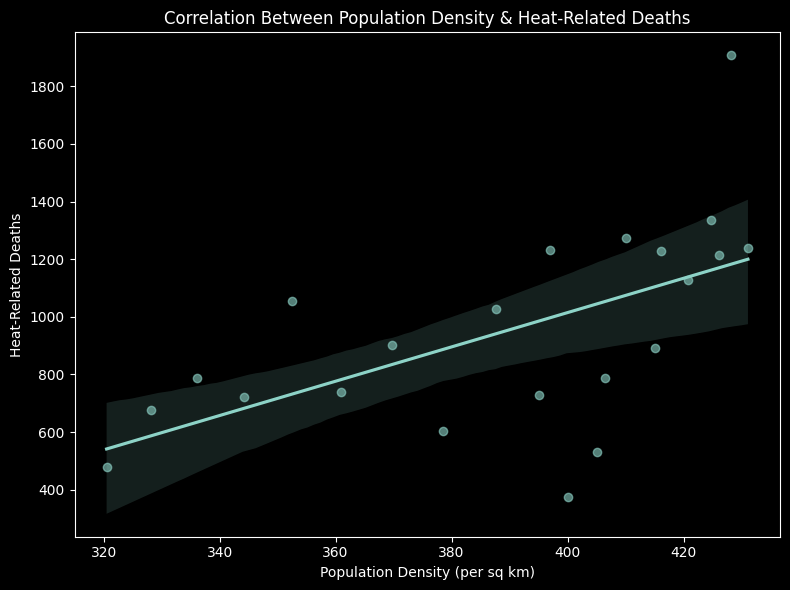

In [11]:

# Set the style to dark
plt.style.use('dark_background')

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))

# Create the regplot
sns.regplot(data=global_data, x="population_density", y="deaths", scatter_kws={'alpha':0.6}, ax=ax)

# Customize the plot
ax.set_xlabel("Population Density (per sq km)")
ax.set_ylabel("Heat-Related Deaths")
ax.set_title("Correlation Between Population Density & Heat-Related Deaths")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [13]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy import stats

# Assuming global_data is your DataFrame
# Create the scatter plot
fig = px.scatter(global_data, x="population_density", y="deaths",
                 title="Correlation Between Population Density & Heat-Related Deaths",
                 labels={"population_density": "Population Density (per sq km)",
                         "deaths": "Heat-Related Deaths"},
                 template="plotly_dark")  # Use a dark theme

# Calculate the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(global_data["population_density"], global_data["deaths"])
line_x = np.array([global_data["population_density"].min(), global_data["population_density"].max()])
line_y = slope * line_x + intercept

# Add the regression line
fig.add_trace(go.Scatter(x=line_x, y=line_y, mode='lines', name='Regression Line',
                         line=dict(color='red')))  # Removed dash='dash'

# Update layout for better appearance
fig.update_layout(
    xaxis_title="Population Density (per sq km)",
    yaxis_title="Heat-Related Deaths",
    legend_title="",
    font=dict(size=12),
    showlegend=True
)

# Show the plot
fig.show()


In [ ]:
fig = px.line(
    merged_df.groupby("year")[["population_density", "deaths"]].sum().reset_index(),
    x="year",
    y=["population_density", "deaths"],
    markers=True,
    title="Year-wise Trends: Population Density vs. Heat-Related Deaths",
    labels={"year": "Year", "value": "Count"},
    template="plotly_dark"
)
fig.show()


In [ ]:


# Aggregate data year-wise (not state-wise)
national_trends = heatwave.groupby("year", as_index=False).sum()

# Merge with national population density
national_trends = national_trends.merge(pop_density, on="year", how="left")

# Plot trends over time
fig = px.line(
    national_trends,
    x="year",
    y=["deaths", "heatwave_days", "population_density"],
    labels={"value": "Count", "variable": "Metric"},
    title="Heatwave Days, Deaths & Population Density",
    template="plotly_dark"
)

fig.show()


In [20]:
import plotly.graph_objects as go

# Aggregate data year-wise (not state-wise)
national_trends = heatwave.groupby("year", as_index=False).sum()

# Merge with national population density
national_trends = national_trends.merge(pop_density, on="year", how="left")

# Create figure
fig = go.Figure()

# Heat-Related Deaths (Left Y-Axis)
fig.add_trace(go.Scatter(
    x=national_trends["year"],
    y=national_trends["deaths"],
    mode="lines+markers",
    name="Heat-Related Deaths",
    marker=dict(color="red"),
    yaxis="y1"
))

# Heatwave Days (Left Y-Axis)
fig.add_trace(go.Scatter(
    x=national_trends["year"],
    y=national_trends["heatwave_days"],
    mode="lines+markers",
    name="Heatwave Days",
    marker=dict(color="orange"),
    yaxis="y1"
))

# Population Density (Right Y-Axis)
fig.add_trace(go.Scatter(
    x=national_trends["year"],
    y=national_trends["population_density"],
    mode="lines+markers",
    name="Population Density",
    marker=dict(color="blue"),
    yaxis="y2"
))

# Layout settings
fig.update_layout(
    title="Heatwave Days, Deaths & Population Density Over Time",
    xaxis=dict(title="Year"),

    # Left Y-Axis (Heat-Related Deaths & Heatwave Days)
    yaxis=dict(
        title="Deaths & Heatwave Days",
        titlefont=dict(color="red"),
        tickfont=dict(color="red"),
    ),

    # Right Y-Axis (Population Density)
    yaxis2=dict(
        title="Population Density",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue"),
        overlaying="y",
        side="right"
    ),

    legend=dict(
        x=1.05,  # Moves the legend to the right
        y=1,
        xanchor="left",
        yanchor="top"
    ),

    #template="plotly_dark"
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# 1. Load Your Data
heatwave = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/merged.csv")

# 2. Ensure Data Types
heatwave['year'] = heatwave['year'].astype(int)

# 3. Filter for selected years
selected_years = [2005, 2015, 2019]
filtered_df = heatwave[heatwave['year'].isin(selected_years)]

# Function to plot state-wise for selected years
def plot_selected_years(df):
    for year in selected_years:
        year_data = df[df['year'] == year]
        fig = px.scatter(
            year_data,
            x="heatwave_days",
            y="deaths",
            color="state_ut",
            size="deaths",
            hover_data=["state_ut", "year"],
            title=f"Heatwave Days vs. Heat-Related Deaths in {year} (State-wise)",
            labels={"heatwave_days": "Heatwave Days", "deaths": "Heat-Related Deaths"},
        )

        # Apply dark theme
        fig.update_layout(template="plotly_dark")

        fig.show()

# Generate plots for 2005, 2015, and 2019
plot_selected_years(filtered_df)


In [ ]:


# Aggregate deaths at the national level (year-wise)
national_deaths = heatwave.groupby("year", as_index=False)["deaths"].sum()

# Merge with national population density
national_data = national_deaths.merge(pop_density, on="year", how="left")

# Scatter plot for national-level trends
fig = px.scatter(
    national_data,
    x="population_density",
    y="deaths",
    color="year",  # Color by year
    size="deaths",
    hover_name="year",
    title="Heat-Related Deaths vs. Population Density",
    labels={
        "population_density": "Population Density (per sq km)",
        "deaths": "Heat-Related Deaths",
        "year": "Year"
    },
    template="plotly_dark"
)

fig.show()


In [ ]:
'''It groups the heatwave data by year and calculates the total number of deaths and heatwave days
for each year at the national level (aggregated across all states or regions).
'''

# Aggregate deaths and heatwave days at the national level (sum over states per year)
national_stats = heatwave.groupby("year", as_index=False).agg({"deaths": "sum", "heatwave_days": "sum"})

# Merge with national population density
national_data = national_stats.merge(pop_density, on="year", how="left")

# Scatter plot: Deaths vs. Population Density (Size represents heatwave days)
fig = px.scatter(
    national_data,
    x="population_density",
    y="deaths",
    color="year",   # Color by year
    size="heatwave_days",  # Marker size represents heatwave days
    hover_name="year",
    title="Heat-Related Deaths vs. Population Density (Heatwave Days as Size)",
    labels={
        "population_density": "Population Density (per sq km)",
        "deaths": "Heat-Related Deaths",
        "heatwave_days": "Heatwave Days",
        "year": "Year"
    },
    template="plotly_dark"
)

fig.show()


In [ ]:
# Scatter plot: Deaths vs. Population Density (Size represents heat-related deaths)
fig = px.scatter(
    national_data,
    x="population_density",
    y="deaths",
    color="year",   # Color by year
    size="deaths",  # Marker size now represents heat-related deaths
    hover_name="year",
    title="Heat-Related Deaths vs. Population Density (Heat-Related Deaths as Size)",
    labels={
        "population_density": "Population Density (per sq km)",
        "deaths": "Heat-Related Deaths",
        "heatwave_days": "Heatwave Days",
        "year": "Year"
    },
    template="plotly_dark"
)

fig.show()


In [ ]:
# Aggregate deaths by state
top_states = heatwave.groupby("state_ut")["deaths"].sum().nlargest(3).index.tolist()

# Filter dataset for only these top states
top_states_df = heatwave[heatwave["state_ut"].isin(top_states)]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Add Heat-Related Deaths (Left Y-Axis)
for state in top_states:
    state_data = top_states_df[top_states_df["state_ut"] == state]  # Store filtered data once
    fig.add_trace(go.Scatter(
        x=state_data["year"], y=state_data["deaths"],
        mode="lines+markers", name=f"{state} Deaths",
        yaxis="y1"
    ))

# Add Heatwave Days (Right Y-Axis)
for state in top_states:
    state_data = top_states_df[top_states_df["state_ut"] == state]  # Reuse filtered data
    fig.add_trace(go.Scatter(
        x=state_data["year"], y=state_data["heatwave_days"],
        mode="lines+markers", name=f"{state} Heatwave Days",
        yaxis="y2", line=dict(dash="dot")  # Dashed line for differentiation
    ))

# Update layout for dual y-axes
fig.update_layout(
    title=dict(
        text="Heat-Related Deaths & Heatwave Days Over Years (Top 3 States)",
        x=0.5,  # Centered title
        y=0.93,  # Lowered to avoid legend overlap
        xanchor="center",
        yanchor="top"
    ),
    xaxis=dict(title="Year"),
    yaxis=dict(title="Heat-Related Deaths", side="left", showgrid=False),
    yaxis2=dict(title="Heatwave Days", side="right", overlaying="y", showgrid=False),

    # Adjust legend position
    legend=dict(
        x=1.05,  # Move legend slightly to the right (outside the graph)
        y=1.0,  # Keep legend at the top
        xanchor="left",
        yanchor="top",
        bgcolor="rgba(50,50,50,0.7)",  # Semi-transparent background
        font=dict(size=10),  # More compact font
        itemwidth=30,  # Reduce item width for compactness
        orientation="v"  # Ensure vertical legend for better readability
    ),

    template="plotly_dark"
)

fig.show()


In [17]:
heatwave.head(3)

,Unnamed: 0,state_ut,year,deaths,heatwave_days,median_wbt
0,0,Andhra Pradesh,2001,46,20,22.679109
1,1,Assam,2001,7,7,19.547613
2,2,Bihar,2001,47,5,23.027893


In [18]:
# Group by 'year' and 'state_ut' and compute the max WBT
max_wbt_per_state = heatwave.groupby(["year", "state_ut"])["median_wbt"].max().reset_index()

# Rename column for clarity
max_wbt_per_state = max_wbt_per_state.rename(columns={"median_wbt": "max_wbt"})

# Display the results
print(max_wbt_per_state.head())


   year        state_ut    max_wbt
0  2001  Andhra Pradesh  22.679109
1  2001           Assam  19.547613
2  2001           Bihar  23.027893
3  2001      Chandigarh  21.861861
4  2001    Chhattisgarh  22.919030


In [19]:

# Merge max_wbt into the heatwave dataset
heatwave = heatwave.merge(max_wbt_per_state, on=["year", "state_ut"], how="left")

# Aggregate Data: Sum of deaths and max of WBT per year
national_trends = heatwave.groupby("year", as_index=False).agg({"deaths": "sum", "max_wbt": "max"})

# Create figure with two y-axes
fig = go.Figure()

# Add Deaths (Left Y-axis)
fig.add_trace(go.Scatter(
    x=national_trends["year"],
    y=national_trends["deaths"],
    mode="lines+markers",
    name="Heat-Related Deaths",
    line=dict(color="red", width=2),
    yaxis="y1"
))

# Add Max WBT (Right Y-axis)
fig.add_trace(go.Scatter(
    x=national_trends["year"],
    y=national_trends["max_wbt"],
    mode="lines+markers",
    name="Max WBT (°C)",
    line=dict(color="orange", width=2, dash="dot"),
    yaxis="y2"
))

# Layout Settings
fig.update_layout(
    title="Heatwave Magnitude (Max WBT) vs. Heat-Related Deaths Over Time",
    #template="plotly_dark",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Heat-Related Deaths", titlefont=dict(color="red"), tickfont=dict(color="red")),
    yaxis2=dict(title="Max Wet Bulb Temperature (°C)", titlefont=dict(color="orange"), tickfont=dict(color="orange"),
                overlaying="y", side="right"),
    legend=dict(x=1.1, y=1),  # Move legend to the right
)

# Show plot
fig.show()


In [ ]:
# Group by 'year' and 'state_ut' and compute the max WBT
max_wbt_per_state = heatwave.groupby(["year", "state_ut"])["median_wbt"].max().reset_index()

# Rename column for clarity
max_wbt_per_state = max_wbt_per_state.rename(columns={"median_wbt": "max_wbt"})

# Display the results
print(max_wbt_per_state.head())


   year        state_ut    max_wbt
0  2001  Andhra Pradesh  22.679109
1  2001           Assam  19.547613
2  2001           Bihar  23.027893
3  2001      Chandigarh  21.861861
4  2001    Chhattisgarh  22.919030


In [ ]:

# Merge max_wbt into the heatwave dataset
heatwave = heatwave.merge(max_wbt_per_state, on=["year", "state_ut"], how="left")

# Aggregate Data: Sum of deaths, heatwave days, max WBT, and population density per year
national_trends = heatwave.groupby("year", as_index=False).agg({
    "deaths": "sum",
    "heatwave_days": "sum",
    "max_wbt": "max"
})

# Merge with population density data
national_trends = national_trends.merge(pop_density, on="year", how="left")

# Create figure with multiple y-axes
fig = go.Figure()

# Heat-Related Deaths (Left Y-axis)
fig.add_trace(go.Scatter(
    x=national_trends["year"],
    y=national_trends["deaths"],
    mode="lines+markers",
    name="Heat-Related Deaths",
    line=dict(color="red", width=2),
    yaxis="y1"
))

# Heatwave Days (Left Y-axis)
fig.add_trace(go.Scatter(
    x=national_trends["year"],
    y=national_trends["heatwave_days"],
    mode="lines+markers",
    name="Heatwave Days",
    line=dict(color="orange", width=2, dash="dash"),
    yaxis="y1"
))

# Max WBT (Right Y-axis)
fig.add_trace(go.Scatter(
    x=national_trends["year"],
    y=national_trends["max_wbt"],
    mode="lines+markers",
    name="Max WBT (°C)",
    line=dict(color="blue", width=2, dash="dot"),
    yaxis="y2"
))

# Population Density (Right Y-axis)
fig.add_trace(go.Scatter(
    x=national_trends["year"],
    y=national_trends["population_density"],
    mode="lines+markers",
    name="Population Density",
    line=dict(color="green", width=2),
    yaxis="y2"
))

# Layout Settings
fig.update_layout(
    title="Heatwave Magnitude (Max WBT), Deaths, Population Density & Heatwave Days Over Time",
    template="plotly_dark",
    xaxis=dict(title="Year"),

    # Left Y-axis (Deaths & Heatwave Days)
    yaxis=dict(
        title="Heat-Related Deaths & Heatwave Days",
        titlefont=dict(color="red"),
        tickfont=dict(color="red"),
    ),

    # Right Y-axis (Max WBT & Population Density)
    yaxis2=dict(
        title="Max Wet Bulb Temperature (°C) & Population Density",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue"),
        overlaying="y",  # Overlay on the same graph
        side="right"
    ),

    # Move legend to the right
    legend=dict(x=1.1, y=1)
)

# Show plot
fig.show()


In [5]:
import pandas as pd
import plotly.express as px

# 1. Load the Data
heatwave = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/merged.csv")

# 2. Ensure Data Types
heatwave['year'] = heatwave['year'].astype(int)

# Function to plot state-wise for each year
def plot_state_year(df):
    for year in df['year'].unique():
        year_data = df[df['year'] == year]
        fig = px.scatter(
            year_data,
            x="heatwave_days",
            y="deaths",
            color="state_ut",
            size="deaths",
            hover_data=["state_ut", "year"],
            title=f"Heatwave Days vs. Heat-Related Deaths in {year} (State-wise)",
            labels={"heatwave_days": "Heatwave Days", "deaths": "Heat-Related Deaths"},
        )

        # Apply dark theme
        fig.update_layout(template="plotly_dark")

        fig.show()

# Generate state-wise plots for each year
plot_state_year(heatwave)

In [ ]:
import pandas as pd
import plotly.express as px

# 1. Load Your Data (Assuming you've already run the merging and preprocessing steps)
heatwave = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/merged.csv")

# 2. Ensure Data Types
heatwave['year'] = heatwave['year'].astype(int)

# Function to plot state-wise for each year
def plot_state_year(df):
    for year in df['year'].unique():
        year_data = df[df['year'] == year]
        fig = px.scatter(
            year_data,
            x="heatwave_days",
            y="deaths",
            color="state_ut",
            size="deaths",
            hover_data=["state_ut", "year"],
            title=f"Heatwave Days vs. Heat-Related Deaths in {year} (State-wise)",
            labels={"heatwave_days": "Heatwave Days", "deaths": "Heat-Related Deaths"},
        )
        fig.show()


# Generate state-wise plots for each year
plot_state_year(heatwave)


In [7]:
import pandas as pd
import plotly.express as px
from IPython.core.display import display, HTML

# Load Your Data
heatwave = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/merged.csv")

# Ensure Data Types
heatwave['year'] = heatwave['year'].astype(int)

# Filter for selected years
selected_years = [2005, 2015, 2019]
filtered_df = heatwave[heatwave['year'].isin(selected_years)]

# Function to plot state-wise for selected years with separators
def plot_selected_years(df):
    for i, year in enumerate(selected_years):
        year_data = df[df['year'] == year]
        fig = px.scatter(
            year_data,
            x="heatwave_days",
            y="deaths",
            color="state_ut",
            size="deaths",
            hover_data=["state_ut", "year"],
            title=f"Heatwave Days vs. Heat-Related Deaths in {year} (State-wise)",
            labels={"heatwave_days": "Heatwave Days", "deaths": "Heat-Related Deaths"},
        )

        # Apply dark theme and adjust margins
        fig.update_layout(template="plotly_dark", margin=dict(l=40, r=40, t=50, b=50))

        fig.show()

        # Add a separator line between plots (except after the last plot)
        if i < len(selected_years) - 1:
            display(HTML("<hr style='border: 1px solid white; margin: 20px 0;'>"))

# Generate plots for 2005, 2015, and 2019 with separators
plot_selected_years(filtered_df)


In [30]:
import pandas as pd
import plotly.express as px
from IPython.core.display import display, HTML

In [16]:

# Load Your Data
heatwave = pd.read_csv("/content/drive/MyDrive/Impact_Scholars/merged.csv")

# Ensure Data Types
heatwave['year'] = heatwave['year'].astype(int)

# Filter for selected years
selected_years = [2005, 2015, 2019]
filtered_df = heatwave[heatwave['year'].isin(selected_years)]

# Function to plot stacked bar charts for selected years
def plot_stacked_bar(df):
    for i, year in enumerate(selected_years):
        year_data = df[df['year'] == year]

        # Create stacked bar chart
        fig = px.bar(
            year_data,
            x="state_ut",
            y=["heatwave_days", "deaths"],
            barmode="stack",
            title=f"Heatwave Days & Deaths in {year} (State-wise)",
            labels={"value": "Count", "state_ut": "State"},
        )

        # Apply dark theme and adjust layout
        fig.update_layout(template="plotly_dark", xaxis_tickangle=-45)

        fig.show()

        # Add a separator line between plots (except after the last plot)
        if i < len(selected_years) - 1:
            display(HTML("<hr style='border: 1px solid white; margin: 20px 0;'>"))

# Generate stacked bar charts for 2005, 2015, and 2019
plot_stacked_bar(filtered_df)


In [31]:


# Ensure Data Types
heatwave['year'] = heatwave['year'].astype(int)

# List of Union Territories to exclude
union_territories = [
    "Andaman & Nicobar Islands", "Chandigarh", "Dadra & Nagar Haveli and Daman & Diu",
    "Lakshadweep", "Delhi", "Puducherry", "Jammu & Kashmir", "Ladakh"
]

# Remove Union Territories
heatwave = heatwave[~heatwave["state_ut"].isin(union_territories)]

# Filter for selected years
selected_years = [2005, 2015, 2019]
filtered_df = heatwave[heatwave['year'].isin(selected_years)]

# Function to plot stacked bar charts
def plot_stacked_bar(df):
    for i, year in enumerate(selected_years):
        year_data = df[df['year'] == year]

        # Create figure
        fig = go.Figure()

        # Stacked Bars: Heatwave Days & Deaths
        fig.add_trace(go.Bar(
            x=year_data["state_ut"], y=year_data["heatwave_days"],
            name="Heatwave Days", marker_color="orange"
        ))

        fig.add_trace(go.Bar(
            x=year_data["state_ut"], y=year_data["deaths"],
            name="Heat-Related Deaths", marker_color="red"
        ))

        # Layout adjustments
        fig.update_layout(
            title=f"Heatwave Days & Heat-Related Deaths in {year} (State-wise, Excluding UTs)",
            xaxis=dict(title="State", tickangle=-45),
            yaxis=dict(title="Count"),
            #template="plotly_dark",
            barmode="stack",  # Stacked bars
            legend=dict(x=1.05, y=1, xanchor="left", yanchor="top", bgcolor="rgba(50,50,50,0.6)")
        )

        fig.show()

        # Add a separator line between plots (except after the last plot)
        if i < len(selected_years) - 1:
            display(HTML("<hr style='border: 1px solid white; margin: 20px 0;'>"))

# Generate stacked bar charts for 2005, 2015, and 2019 (excluding Union Territories)
plot_stacked_bar(filtered_df)
